In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib
# matplotlib.use('Qt5Agg',force=True)
# matplotlib.use("TKAgg",force=True)
# matplotlib.use("widget",force=True)
import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np

sys.path.append(r"/users/mjk557/scratch/scripts/sdtools")
sys.path.append(r"/ssd_scratch/scripts/sdtools")

from analysis import *
import h2D
import grid_fields

In [6]:
# meshwrapper = grid_fields.Mesh(r"/ssd_scratch/hcases/g3a4t1-source_test.nc")
meshwrapper = grid_fields.Mesh(r"/ssd_scratch/hcases/g3a4f2-allflux.nc")

In [14]:
v_innercore = meshwrapper.dv[meshwrapper.slices("inner_core_edge")].sum() + meshwrapper.dv[meshwrapper.slices("outer_core_edge")].sum()

hflux_i = 1e6    # In W
hflux_e = 0.76e6

mflux_i = 1.5e21    # ions/s. Core net ion flux 0.3 + puff of 1.2.

hsrc_i = hflux_i / v_innercore    # In Wm-3 or Pa/s
hsrc_e = hflux_e / v_innercore    # In Wm-3 or Pa/s
msrc_i = mflux_i / v_innercore

Pd_src = grid_fields.Field("Pd+_src", meshwrapper)
Pd_src.data[meshwrapper.slices("all")] = 0
Pd_src.data[meshwrapper.slices("inner_core_edge")] = hsrc_i
Pd_src.data[meshwrapper.slices("outer_core_edge")] = hsrc_i

Pe_src = grid_fields.Field("Pe_src", meshwrapper)
Pe_src.data[meshwrapper.slices("all")] = 0
Pe_src.data[meshwrapper.slices("inner_core_edge")] = hsrc_e
Pe_src.data[meshwrapper.slices("outer_core_edge")] = hsrc_e

Nd_src = grid_fields.Field("Nd+_src", meshwrapper)
Nd_src.data[meshwrapper.slices("all")] = 0
Nd_src.data[meshwrapper.slices("inner_core_edge")] = msrc_i
Nd_src.data[meshwrapper.slices("outer_core_edge")] = msrc_i

meshwrapper.write_field(Pd_src)
meshwrapper.write_field(Pe_src)
meshwrapper.write_field(Nd_src)

>>> Field Pd+_src already exists in /ssd_scratch/hcases/g3a4t1-source_test.nc, it will be overwritten
-> Wrote field Pd+_src to /ssd_scratch/hcases/g3a4t1-source_test.nc
>>> Field Pe_src already exists in /ssd_scratch/hcases/g3a4t1-source_test.nc, it will be overwritten
-> Wrote field Pe_src to /ssd_scratch/hcases/g3a4t1-source_test.nc
>>> Field Nd+_src already exists in /ssd_scratch/hcases/g3a4t1-source_test.nc, it will be overwritten
-> Wrote field Nd+_src to /ssd_scratch/hcases/g3a4t1-source_test.nc


In [7]:
m = meshwrapper.mesh

for param in ["Pd+_src", "Pe_src", "Nd+_src"]:
    print(f'\n-> {param}:')
    print(f'Set: {set(m[param].flatten())}')
    print(f'Integral: {(m[param].squeeze() * meshwrapper.dv).sum()}')



-> Pd+_src:
Set: {0.0, 9209709.214577591}
Integral: 1000000.0

-> Pe_src:
Set: {0.0, 6999379.003078969}
Integral: 760000.0

-> Nd+_src:


KeyError: 'No variable found: Nd+_src'

In [4]:
self = h2D.Load.case_2D(r"/ssd_scratch/hcases/t3-source_test", r"/ssd_scratch/hcases/g3a4-lores.nc")

/ssd_scratch/hcases/g3a4-lores.nc
/ssd_scratch/hcases/t3-source_test
CHECK: Total domain volume is 1.607E+00 [m3]


In [5]:
self.ds["Sd+_src_denorm"] = self.ds["Sd+_src"].copy()
self.ds["Sd+_src_denorm"] *= self.ds.metadata["Nnorm"] * self.ds.metadata["Omega_ci"]

for param in ["Pd+_src", "Pe_src", "Sd+_src"]:
    print(f'\n-> {param}:')
    print(f'Set: {set(self.ds[param].isel(t=-1).values.flatten())}')
    print(f'Integral: {(self.ds[param].isel(t=-1).squeeze() * self.ds.dv).sum()}')


-> Pd+_src:
Set: {0.0, 9209709.134102114}
Integral: 999999.9912618872

-> Pe_src:
Set: {0.0, 6999378.941917607}
Integral: 759999.9933590344

-> Sd+_src:
Set: {0.0, 1.3814563821866386e+22}
Integral: 1.5e+21


In [3]:

self = h2D.Load.case_2D(r"/ssd_scratch/hcases/t1-dirichlet", r"/ssd_scratch/hcases/g3a4-lores.nc")
# self.diagnose_cvode()

case = self

/ssd_scratch/hcases/g3a4-lores.nc
/ssd_scratch/hcases/t1-dirichlet


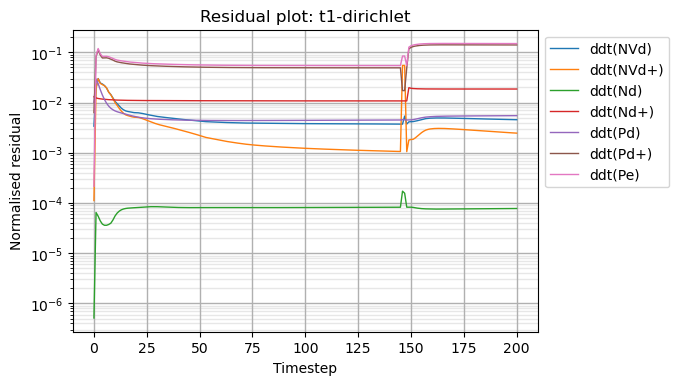

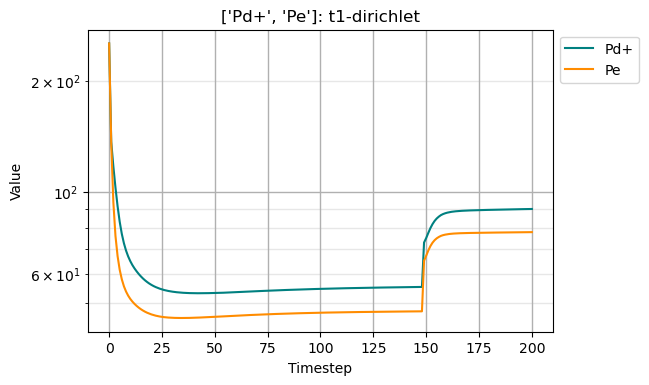

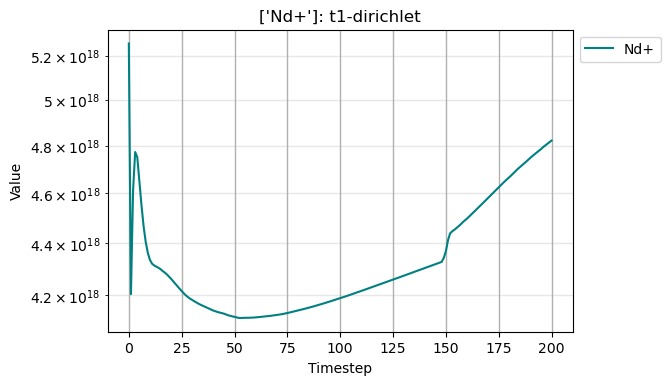

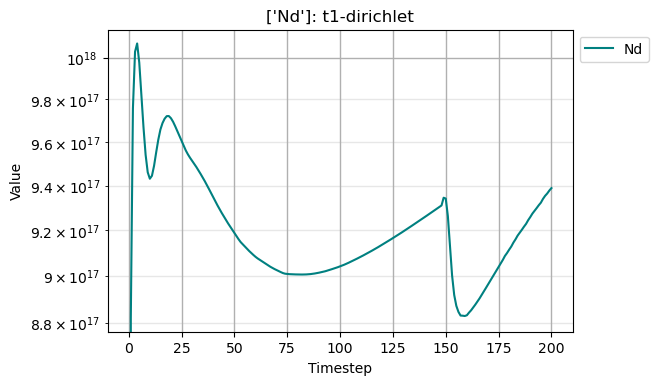

In [4]:
self.plot_ddt(smoothing = 1)
# self.plot_ddt(smoothing = 20)
self.plot_monitors(["Pd+", "Pe"], what = ["mean"])
self.plot_monitors(["Nd+"], what = "mean")
self.plot_monitors(["Nd"], what = "mean")

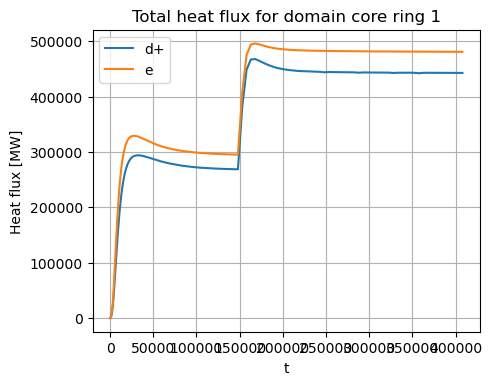

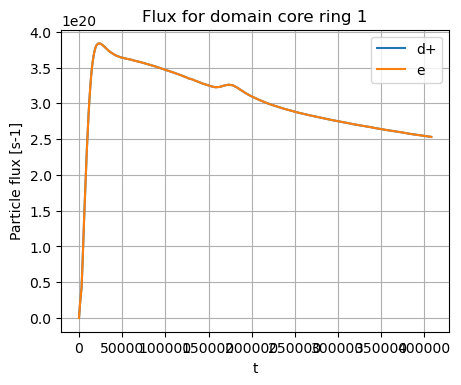

In [5]:
ring = h2D.CoreRing(self, ring_index = 1)
ring.D["d+"] = 1; ring.D["e"] = 1;
ring.Chi["d+"] = 3; ring.Chi["e"] = 3;
ring.calculate_fluxes()
ring.sum_fluxes()
ring.plot_heat_flux_history()
ring.plot_particle_flux_history()

In [3]:
case = self

domain = h2D.Region(case, case.slices("all"))
core_ring = h2D.CoreRing(case, ring_index = 0)

core_i_source = domain.integrals["Pd+_src"] * 1e-6 
core_e_source = domain.integrals["Pe_src"] * 1e-6
rad_iz = domain.integrals["Rd+_ex"] * 1e-6 * -1    # MW
rad_rec = domain.integrals["Rd+_rec"] * 1e-6 * -1  # MW
core_i_power = core_ring.total_heat_flux["d+"].squeeze() * 1e-6    # MW
core_e_power = core_ring.total_heat_flux["e"].squeeze() * 1e-6    # MW


print(f"- Ion power source: {core_i_source[-1]:,.1f}MW")
print(f"- Electron power source: {core_e_source[-1]:,.1f}MW")
print(f"- Ion power leaving core: {core_i_power[-1]:,.1f}MW")
print(f"- Electron power leaving core: {core_e_power[-1]:,.1f}MW")
print(f"- Total ionisation radiation: {rad_iz[-1]:,.1f}MW")
print(f"- Total recombination radiation: {rad_rec[-1]:,.1f}MW")

- Ion power source: 1.0MW
- Electron power source: 0.0MW
- Ion power leaving core: 0.3MW
- Electron power leaving core: 0.1MW
- Total ionisation radiation: -36.3MW
- Total recombination radiation: -0.0MW


In [5]:
set(case.ds["Pe_src"].isel(t=-1).values.flatten())

{0.0, 0.0009121504922593}

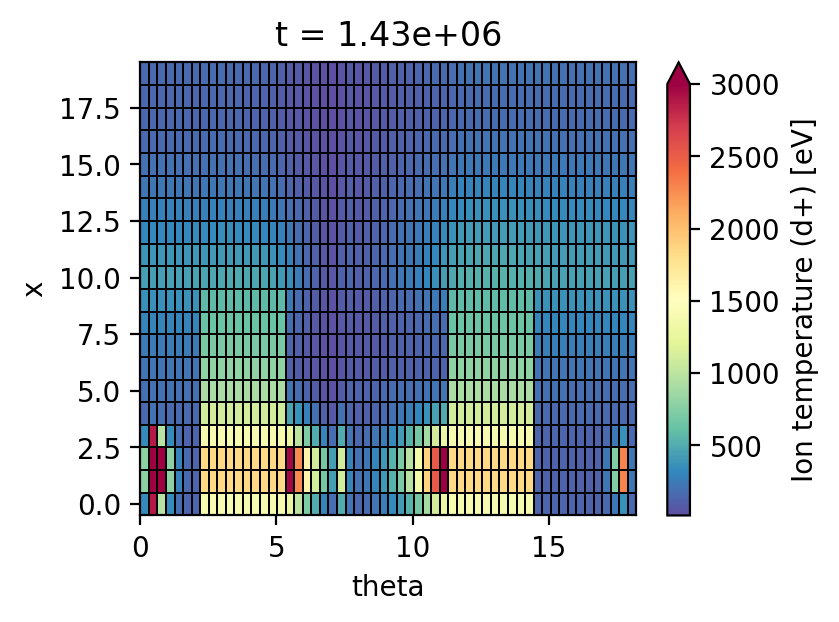

In [26]:
fig, ax = plt.subplots(figsize=(4,3),dpi = 200)
# self.ds["Pd+_src"].isel(t=-1).plot(ax = ax, cmap = "Spectral_r", color = "k", linewidth = 0.01, vmin = 0, vmax = None)
self.ds["Td+"].isel(t=-1).plot(ax = ax, cmap = "Spectral_r", color = "k", linewidth = 0.01, vmin = None, vmax = 3000)

(-0.9, -0.6)

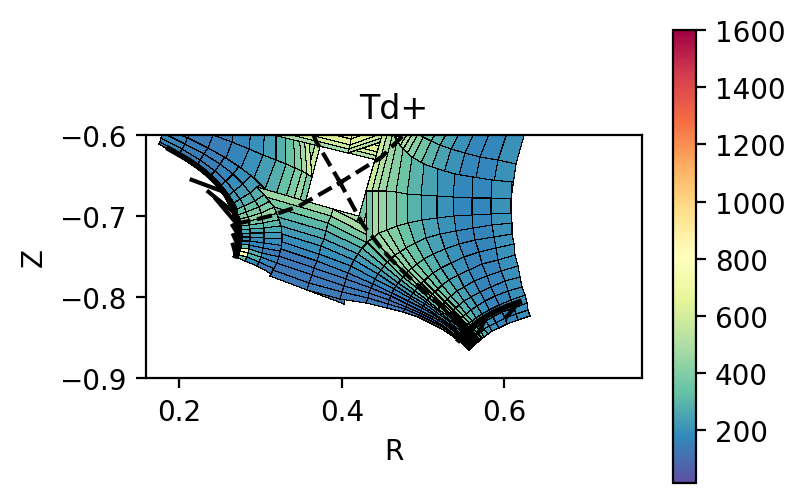

In [30]:
fig, ax = plt.subplots(figsize=(4,3),dpi = 200)
self.ds["Td+"].isel(t=-1).bout.pcolormesh(ax = ax, cmap = "Spectral_r", color = "k", linewidth = 0.01, vmin = None, vmax = 1600)
# ax.set_ylim(0.4, 0.88)
ax.set_ylim(-0.9, -0.6)

[(-0.9, 0.0), (-0.9, 0.0), (-0.9, 0.0), (-0.9, 0.0)]

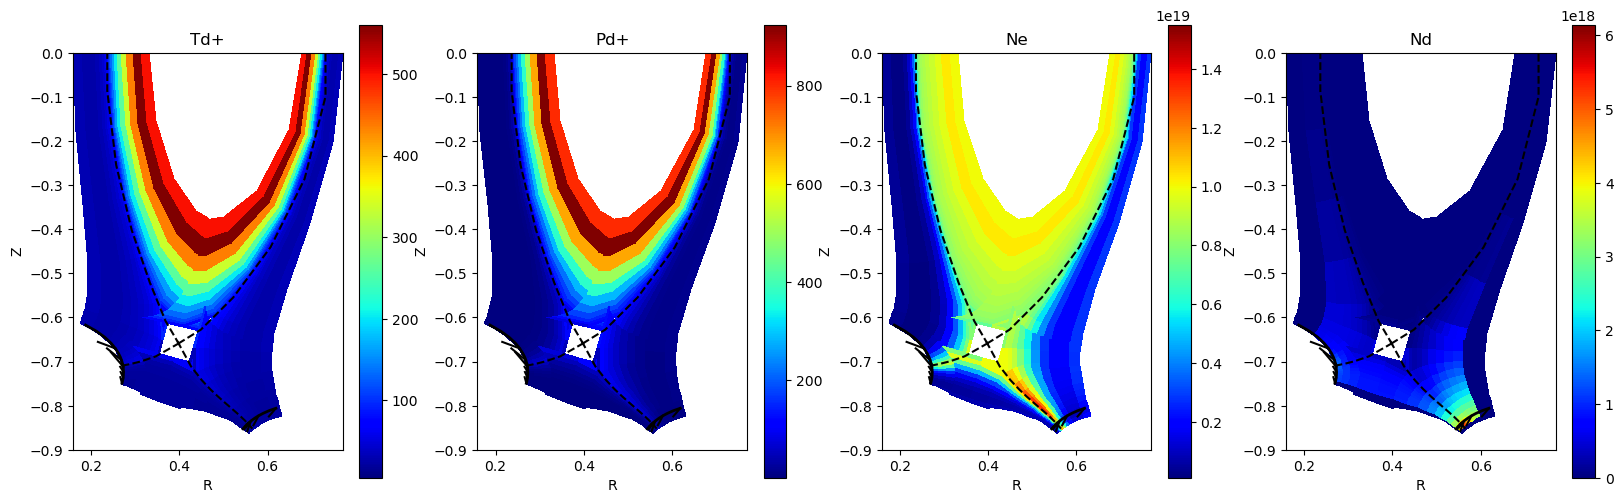

In [6]:
data = self.ds

cols = 4
fig, axes = plt.subplots(1,cols, figsize = (cols*5,6), dpi = 100)

data["Td+"].isel(t=-1).bout.pcolormesh(ax = axes[0], cmap = "jet", logscale = False,
# vmin = 53, vmax = 1600, 
)
data["Pd+"].isel(t=-1).bout.pcolormesh(ax = axes[1], cmap = "jet", logscale = False,
# vmin = 2.2, vmax = 1400, 
)
data["Ne"].isel(t=-1).bout.pcolormesh(ax = axes[2], cmap = "jet", logscale = False,
# vmin = 1.1e15, vmax = 7.2e19, 
)
data["Nd"].isel(t=-1).bout.pcolormesh(ax = axes[3], cmap = "jet", logscale = False,
# vmin = 9.7e13, vmax = 2.9e19, 
)
[ax.set_ylim(-0.9,0) for ax in axes]